## Setup

This week we talked about word embeddings. Let's see how we use `word2vec` to produce word embeddings and then find some use to these embeddings (this code is adapted from [this tutorial](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook) and [this tutorial](https://carpentries-incubator.github.io/python-text-analysis/07-wordEmbed_intro/index.html)). We start, as we usually do, by loading some libraries:

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

We will be using, once more, our presidential candidates' tweets dataset. 

In [69]:
df = pd.read_csv('/Users/sebastianvallejo/Library/CloudStorage/OneDrive-UniversityOfHouston/UWO/Computational Text Analysis/cpa-code/data/candidate-tweets.csv')
df.head()

,screen_name,text,datetime,source,lang
0,realDonaldTrump,RT @GeraldoRivera: Recruit @realDonaldTrump to...,2015-04-23 16:04,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",en
1,realDonaldTrump,".@GeraldoRivera Thanks, my champion Geraldo--a...",2015-04-23 16:04,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",en
2,realDonaldTrump,"Trump signs lease for a NH office, returns Mon...",2015-04-23 16:53,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",en
3,realDonaldTrump,Excited to be travelling to New Hampshire on M...,2015-04-23 17:08,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",en
4,realDonaldTrump,Via @thehill by @HenschOnTheHill: Trump says U...,2015-04-23 17:50,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",en


## Pre-processing

We can lemmatize and remove the stopwords and non-alphabetic characters for each line of dialogue (as we did in R):

In [70]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # Loading the English vesion of Spacy. Also disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:

In [174]:
brief_cleaning = (re.sub("[^A-Za-z']+|[^\w\s]|http\S+|RT", ' ', str(row)).lower() for row in df['text'])

Taking advantage of spaCy `.pipe()` attribute to speed-up the cleaning process:

In [99]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.53 mins


Put the results in a DataFrame:

In [103]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean['clean'][30]

'  rmutt realdonaldtrump la loquita need trump fix cuntry trumpisawesome trumpcard capitalism'

### Bi-grams and phrases

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. You can find a description of a function [here](https://radimrehurek.com/gensim/models/phrases.html). The main reason we do this is to catch words like "white_house" or "united_states".

In [104]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean['clean']] # As Phrases() takes a list of list of words as input
phrases = Phrases(sent, min_count=30, progress_per=10000) # Creates the relevant phrases from the list of sentences

INFO - 12:08:58: collecting all words and their counts
INFO - 12:08:58: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:08:58: PROGRESS: at sentence #10000, processed 97812 words and 73526 word types
INFO - 12:08:58: PROGRESS: at sentence #20000, processed 190503 words and 124232 word types
INFO - 12:08:58: collected 152227 token types (unigram + bigrams) from a corpus of 244978 words and 25694 sentences
INFO - 12:08:58: merged Phrases<152227 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 12:08:58: Phrases lifecycle event {'msg': 'built Phrases<152227 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2024-01-24T12:08:58.322922', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}


According to [Pierre Megret](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook), the goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [105]:
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 12:09:02: exporting phrases from Phrases<152227 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 12:09:02: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<135 phrases, min_count=30, threshold=10.0> from Phrases<152227 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2024-01-24T12:09:02.837650', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}


### Most Frequent Words

Now we can check the results of our lemmatization, removal of stopwords, and addition of bigrams. We can see if there is anything funky going on, and adjust accordingly:

In [106]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

20402

In [107]:
sorted(word_freq, key=word_freq.get, reverse=True)[:15]

['s',
 'u',
 'tedcruz',
 'realdonaldtrump',
 'trump',
 'hillary',
 'amp',
 'thank',
 'need',
 'today',
 'great',
 'join',
 'vote',
 'people',
 'president']

Looks ok for now. 

## Training the Model

Again, here I follow most of [Pierre Megret](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook)'s direction on training Word2Vec models using Gensim. [Gensim](https://radimrehurek.com/gensim/intro.html#what-is-gensim) (Generate Similar) is a "a free open-source Python library for representing documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible". If you are interested in understanding the full range of application of the Gensim library (including Word2Vec), I encourage you to check out their website (and the thousands of tutorials out there). 

Megret divides the training of Word2Vec intro three steps in order to monitor the process. One of the main criticisms to Machine-Learning models is that they are a bit of blackbox, since we don't really know (or can interpret) the inner working of the computer. Thus, having as much control as possible to latter adjust our models is always good practice. Here are the steps:

1. `Word2Vec()`: Set up the parameters of the model.
2. `.build_vocab()`: Build the vocabulary from a sequence of sentences and initialize the model. Here we can monitor `min_count` and `sample`.
3. `.train()`: Train the model.

### Parameters

- `min_count` = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- `window` = int - The maximum distance between the current and predicted word within a sentence (i.e., window words on the left and window words on the right of our target) - (2, 10)
- `vector_size` = int - Dimensionality of the feature vectors. - (50, 300)
- `sample` = float - The threshold for configuring which higher-frequency words are randomly downsampled. **Highly influencial**. - (0, 1e-5)
- `alpha` = float - The initial learning rate (i.e., how much of a jump when finding maxima) - (0.01, 0.05)
- `min_alpha` = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
- `negative` = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- `workers` = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [109]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores 

12

In [111]:

w2v_model = Word2Vec(min_count=15, # Since our corpus is not very big
                     window=3,
                     vector_size=150,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 12:10:14: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=150, alpha=0.03>', 'datetime': '2024-01-24T12:10:14.018654', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}


### Building Vocabulary Table

`Word2Vec` requires us to build the vocabulary table (digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [112]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:10:17: collecting all words and their counts
INFO - 12:10:17: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:10:17: PROGRESS: at sentence #10000, processed 93636 words, keeping 12551 word types
INFO - 12:10:17: PROGRESS: at sentence #20000, processed 181347 words, keeping 17781 word types
INFO - 12:10:17: collected 20402 word types from a corpus of 232810 raw words and 25694 sentences
INFO - 12:10:17: Creating a fresh vocabulary
INFO - 12:10:17: Word2Vec lifecycle event {'msg': 'effective_min_count=15 retains 2196 unique words (10.76% of original 20402, drops 18206)', 'datetime': '2024-01-24T12:10:17.502482', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
INFO - 12:10:17: Word2Vec lifecycle event {'msg': 'effective_min_count=15 leaves 189989 word corpus (81.61% of original 232810, drops 42821)', 'datetime': 

Time to build vocab: 0.0 mins


There is useful information in the output. It allows us to monitor how many tokens are being dropped and how many are being *downsampled*.

### Traing the Model

Parameters of training:
    - `total_examples`: int - Count of sentences (in our case, what was left after `min_count` and `sample`).
    - `epochs` = int - Number of iterations (epochs) over the corpus - [10, 20, 30].

In [113]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:10:27: Word2Vec lifecycle event {'msg': 'training model with 11 workers on 2196 vocabulary and 150 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2024-01-24T12:10:27.728685', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 12:10:27: EPOCH 0: training on 232810 raw words (76617 effective words) took 0.1s, 544789 effective words/s
INFO - 12:10:28: EPOCH 1: training on 232810 raw words (76530 effective words) took 0.1s, 622136 effective words/s
INFO - 12:10:28: EPOCH 2: training on 232810 raw words (77091 effective words) took 0.1s, 612232 effective words/s
INFO - 12:10:28: EPOCH 3: training on 232810 raw words (76900 effective words) took 0.1s, 629331 effective words/s
INFO - 12:10:28: EPOCH 4: training on 232810 raw words (77071 effective words) took 0.2s, 361970 effective words/s
INFO - 12:1

Time to train the model: 0.07 mins


## Exploring the Model

Now we can start looking at some results. For example, we can see what words are more closely related to 'government':

In [114]:
w2v_model.wv.most_similar(positive=["government"])

[('corporate', 0.9181435704231262),
 ('handful', 0.9048110246658325),
 ('taxpayer', 0.892824113368988),
 ('disagree', 0.8859014511108398),
 ('welfare', 0.8830430507659912),
 ('corporation', 0.8828763365745544),
 ('interest', 0.8811125755310059),
 ('contributor', 0.8752729296684265),
 ('federal', 0.8737192153930664),
 ('individual', 0.8694367408752441)]

Interesting. From here we can start thinking about why these words are closely related to *government*. Alternatively, we can see what is the similarity of two words provided by us:

In [127]:
w2v_model.wv.similarity('trump', 'win')

0.55334723

In [128]:
w2v_model.wv.similarity('hillary', 'win')

0.42378747

In [129]:
w2v_model.wv.similarity('bernie', 'win')

0.4575468

In [130]:
w2v_model.wv.similarity('cruz', 'win')

0.464712

Speaks volumes... Another interesting feature is determing which word is the odd-one-out:

In [131]:
w2v_model.wv.doesnt_match(['hillary', 'trump', 'bernie'])

'trump'

Makes sense, as Trump is Republican, and Hillary and Bernie are Democrats. 

### t-SNE Visualizations

t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data (each embedding is 150 dimensions long... what does this even mean?) and the underlying relationships between vectors in a lower-dimensional space (two-dimensions... easier to interpret).

In [132]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

In [182]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 150), dtype='f') # Change this according to dimensions
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 150 to 15 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

Let's compare where the vector representation of *president* and his 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to *president*:

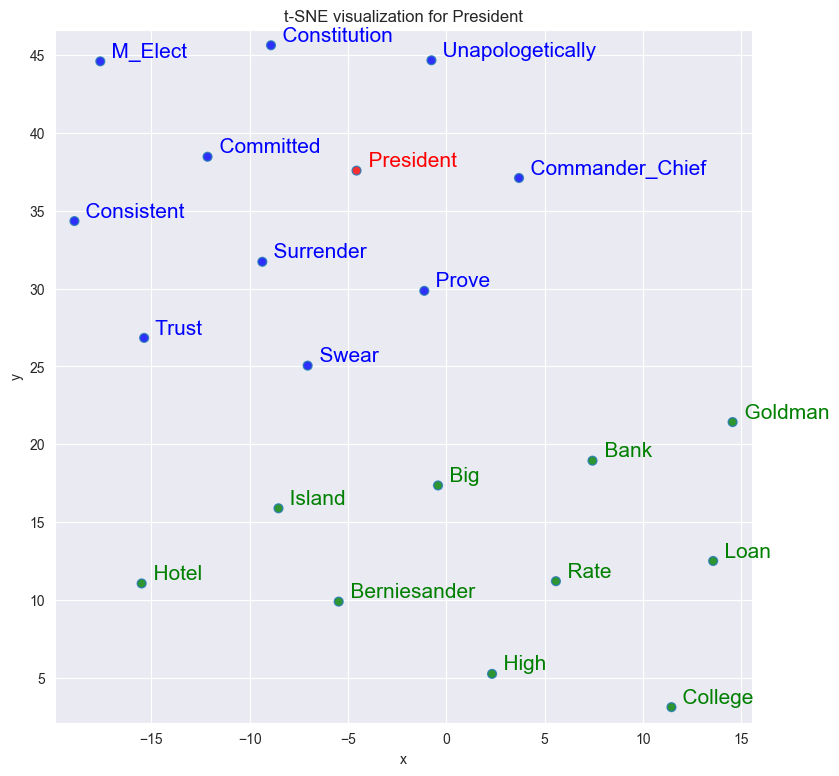

In [183]:
tsnescatterplot(w2v_model, 'president', [i[0] for i in w2v_model.wv.most_similar(negative=["president"])])

Bernie didn't stand a chance. Or we could explore concepts like the *economy*. 

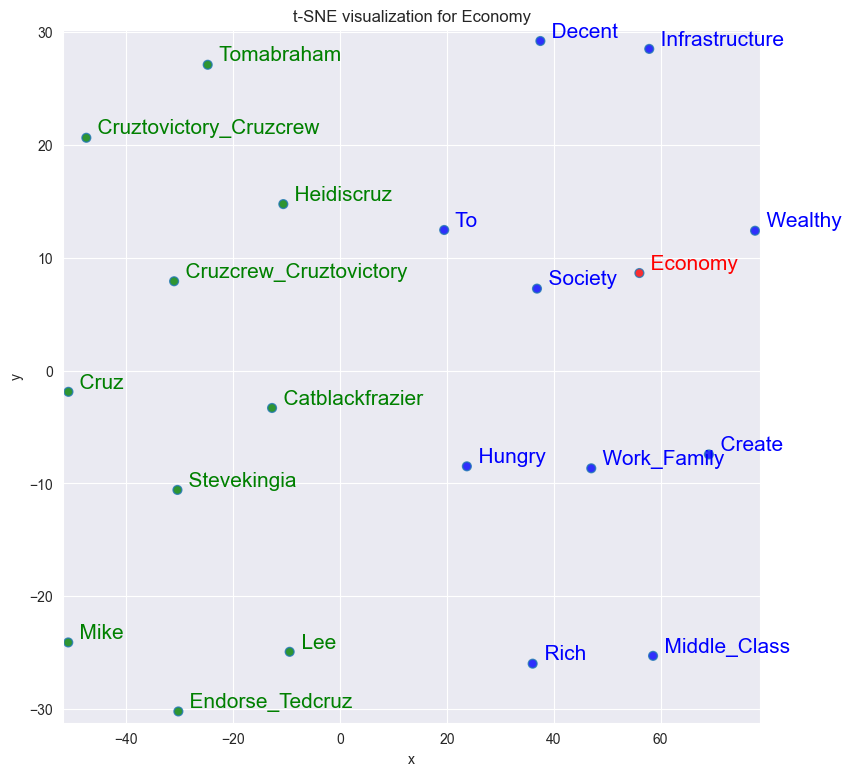

In [184]:
tsnescatterplot(w2v_model, 'economy', [i[0] for i in w2v_model.wv.most_similar(negative=["economy"])])

Since embeddings have 'meaning', we can train our corpus for each candidate and see how the 'meaning' of *country* varies across them. 

In [175]:
df_trump = df[df['screen_name']=='realDonaldTrump']
brief_cleaning = (re.sub("[^A-Za-z']+|[^\w\s]|http\S+|RT", ' ', str(row)).lower() for row in df_trump['text'])
txt_trump = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_trump_clean = pd.DataFrame({'clean': txt_trump})
df_trump_clean = df_trump_clean.dropna().drop_duplicates()
sent_trump = [row.split() for row in df_trump_clean['clean']] # As Phrases() takes a list of list of words as input
phrases_trump = Phrases(sent_trump, min_count=30, progress_per=10000) # Creates the relevant phrases from the list of sentences
bigram_trump = Phraser(phrases_trump)
sentences_trump = bigram_trump[sent_trump]

w2v_trump = Word2Vec(min_count=15, # Since our corpus is not very big
                     window=3,
                     vector_size=150,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
w2v_trump.build_vocab(sentences_trump, progress_per=10000)
w2v_trump.train(sentences_trump, total_examples=w2v_trump.corpus_count, epochs=30, report_delay=1)


INFO - 13:37:27: collecting all words and their counts
INFO - 13:37:27: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:37:27: collected 54489 token types (unigram + bigrams) from a corpus of 71075 words and 7242 sentences
INFO - 13:37:27: merged Phrases<54489 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:37:27: Phrases lifecycle event {'msg': 'built Phrases<54489 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.03s', 'datetime': '2024-01-24T13:37:27.141786', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 13:37:27: exporting phrases from Phrases<54489 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:37:27: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<25 phrases, min_count=30, threshold=10.0> from Phrases<54489 vocab, min_count=30, threshold

(344551, 2061870)

In [176]:
df_hillary = df[df['screen_name']=='HillaryClinton']
brief_cleaning = (re.sub("[^A-Za-z']+|[^\w\s]|http\S+|RT", ' ', str(row)).lower() for row in df_hillary['text'])
txt_hillary = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_hillary_clean = pd.DataFrame({'clean': txt_hillary})
df_hillary_clean = df_hillary_clean.dropna().drop_duplicates()
sent_hillary = [row.split() for row in df_hillary_clean['clean']] # As Phrases() takes a list of list of words as input
phrases_hillary = Phrases(sent_hillary, min_count=30, progress_per=10000) # Creates the relevant phrases from the list of sentences
bigram_hillary = Phraser(phrases_hillary)
sentences_hillary = bigram_hillary[sent_hillary]

w2v_hillary = Word2Vec(min_count=15, # Since our corpus is not very big
                     window=3,
                     vector_size=150, 
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
w2v_hillary.build_vocab(sentences_hillary, progress_per=10000)
w2v_hillary.train(sentences_hillary, total_examples=w2v_hillary.corpus_count, epochs=30, report_delay=1)

INFO - 13:41:36: collecting all words and their counts
INFO - 13:41:36: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:41:36: collected 39003 token types (unigram + bigrams) from a corpus of 54797 words and 5509 sentences
INFO - 13:41:36: merged Phrases<39003 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:41:36: Phrases lifecycle event {'msg': 'built Phrases<39003 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.02s', 'datetime': '2024-01-24T13:41:36.165818', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 13:41:36: exporting phrases from Phrases<39003 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:41:36: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<25 phrases, min_count=30, threshold=10.0> from Phrases<39003 vocab, min_count=30, threshold

(227335, 1595190)

In [177]:
df_bernie = df[df['screen_name']=='BernieSanders']
brief_cleaning = (re.sub("[^A-Za-z']+|[^\w\s]|http\S+|RT", ' ', str(row)).lower() for row in df_bernie['text'])
txt_bernie = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_bernie_clean = pd.DataFrame({'clean': txt_bernie})
df_bernie_clean = df_bernie_clean.dropna().drop_duplicates()
sent_bernie = [row.split() for row in df_bernie_clean['clean']] # As Phrases() takes a list of list of words as input
phrases_bernie = Phrases(sent_bernie, min_count=30, progress_per=10000) # Creates the relevant phrases from the list of sentences
bigram_bernie = Phraser(phrases_bernie)
sentences_bernie = bigram_bernie[sent_bernie]

w2v_bernie = Word2Vec(min_count=15, # Since our corpus is not very big
                     window=3,
                     vector_size=150, 
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
w2v_bernie.build_vocab(sentences_bernie, progress_per=10000)
w2v_bernie.train(sentences_bernie, total_examples=w2v_bernie.corpus_count, epochs=30, report_delay=1)

INFO - 13:41:47: collecting all words and their counts
INFO - 13:41:47: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:41:47: collected 27465 token types (unigram + bigrams) from a corpus of 37522 words and 3856 sentences
INFO - 13:41:47: merged Phrases<27465 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:41:47: Phrases lifecycle event {'msg': 'built Phrases<27465 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2024-01-24T13:41:47.836528', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 13:41:47: exporting phrases from Phrases<27465 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:41:47: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<19 phrases, min_count=30, threshold=10.0> from Phrases<27465 vocab, min_count=30, threshold

(138761, 1090470)

In [178]:
df_tedcruz = df[df['screen_name']=='tedcruz']
brief_cleaning = (re.sub("[^A-Za-z']+|[^\w\s]|http\S+|RT", ' ', str(row)).lower() for row in df_tedcruz['text'])
txt_tedcruz = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_tedcruz_clean = pd.DataFrame({'clean': txt_tedcruz})
df_tedcruz_clean = df_tedcruz_clean.dropna().drop_duplicates()
sent_tedcruz = [row.split() for row in df_tedcruz_clean['clean']] # As Phrases() takes a list of list of words as input
phrases_tedcruz = Phrases(sent_tedcruz, min_count=30, progress_per=10000) # Creates the relevant phrases from the list of sentences
bigram_tedcruz = Phraser(phrases_tedcruz)
sentences_tedcruz = bigram_tedcruz[sent_tedcruz]

w2v_tedcruz = Word2Vec(min_count=15, # Since our corpus is not very big
                     window=3,
                     vector_size=150, 
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
w2v_tedcruz.build_vocab(sentences_tedcruz, progress_per=10000)
w2v_tedcruz.train(sentences_tedcruz, total_examples=w2v_tedcruz.corpus_count, epochs=30, report_delay=1)

INFO - 13:42:01: collecting all words and their counts
INFO - 13:42:01: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:42:01: collected 54159 token types (unigram + bigrams) from a corpus of 81646 words and 9091 sentences
INFO - 13:42:01: merged Phrases<54159 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:42:01: Phrases lifecycle event {'msg': 'built Phrases<54159 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.03s', 'datetime': '2024-01-24T13:42:01.867460', 'gensim': '4.3.2', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 13:42:01: exporting phrases from Phrases<54159 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:42:01: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<48 phrases, min_count=30, threshold=10.0> from Phrases<54159 vocab, min_count=30, threshold

(447395, 2347650)

Not the nicest code, but at least we can not see the differences on how each camp embeds meaning to *country*:

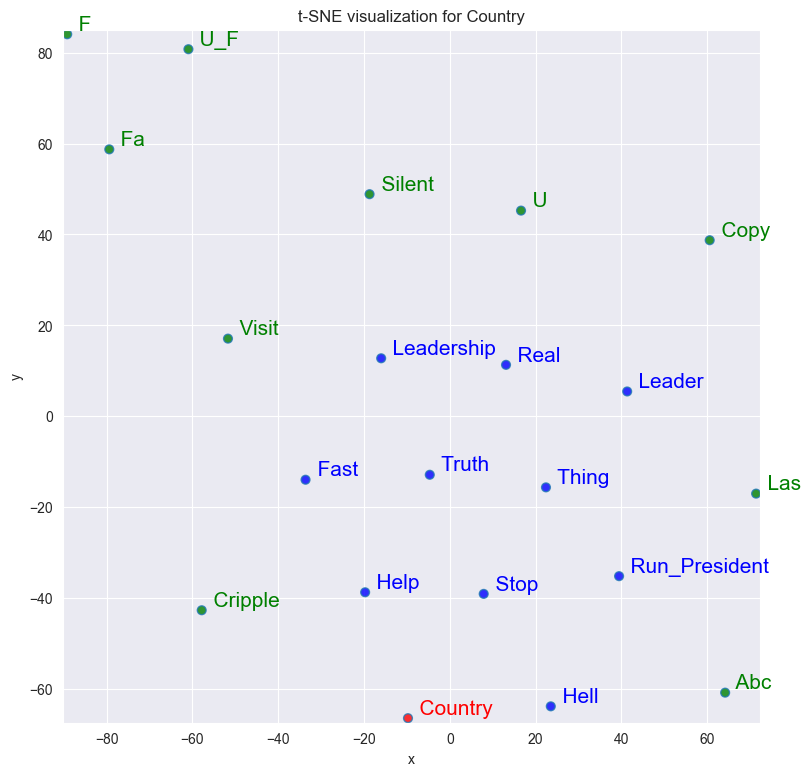

In [185]:
tsnescatterplot(w2v_trump, 'country', [i[0] for i in w2v_trump.wv.most_similar(negative=["country"])])

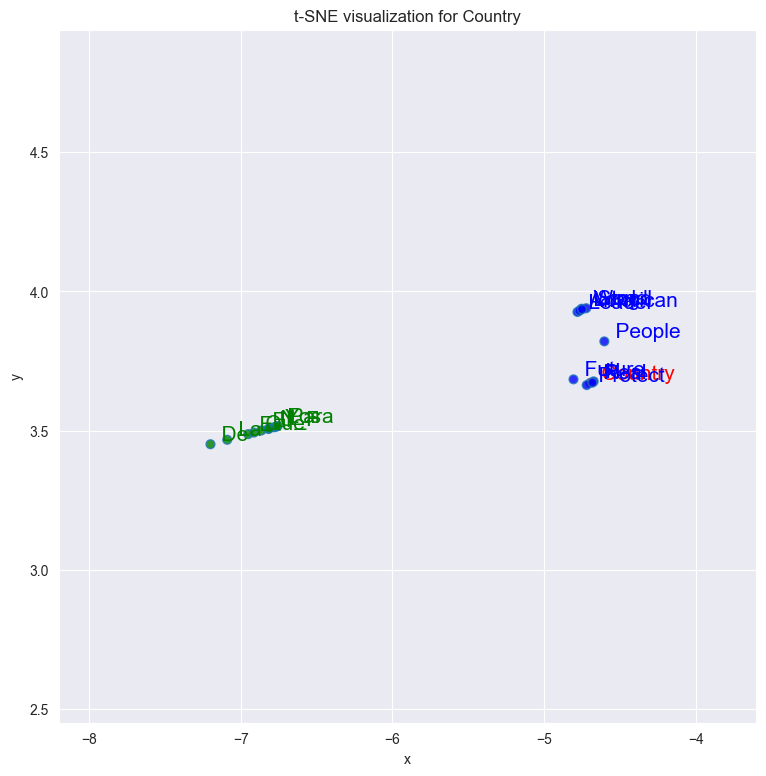

In [195]:
tsnescatterplot(w2v_hillary, 'country', [i[0] for i in w2v_hillary.wv.most_similar(negative=["country"])])

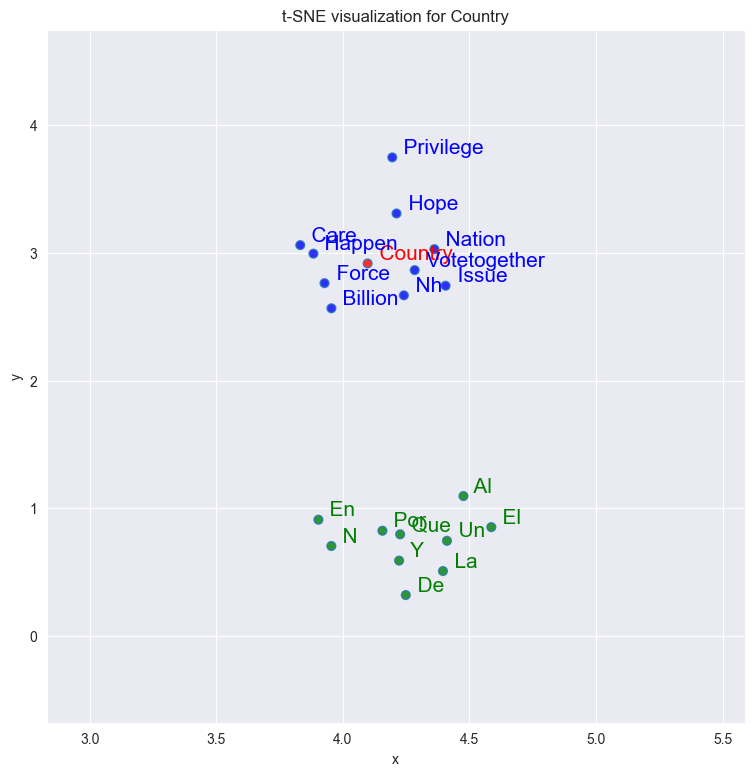

In [197]:
tsnescatterplot(w2v_bernie, 'country', [i[0] for i in w2v_bernie.wv.most_similar(negative=["country"])])

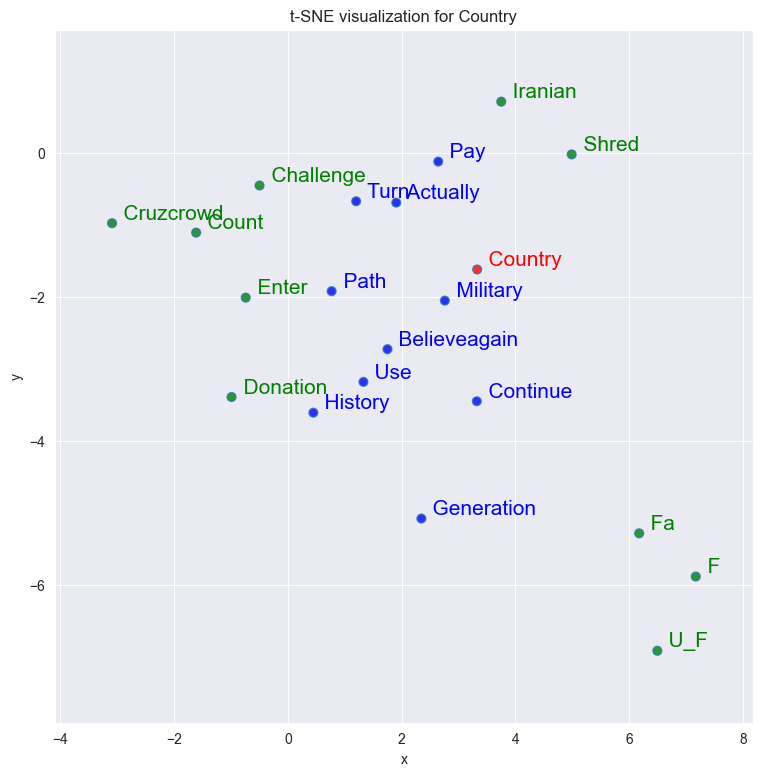

In [198]:
tsnescatterplot(w2v_tedcruz, 'country', [i[0] for i in w2v_tedcruz.wv.most_similar(negative=["country"])])